# Statistical Downscaling and Bias-Adjustment

`xclim` provides tools and utilities to ease the bias-adjustement process through its `xclim.sdba` module. Adjustment algorithms all conform to the `train` - `adjust` scheme, formalized within `Adjustment` classes. Given a reference time series (ref), historical simulations (hist) and simulations to be adjusted (sim), any bias-adjustment method would be applied by first estimating the adjustment factors between the historical simulation and the observations series, and then applying these factors to `sim`, which could be a future simulation.

A very simple "Quantile Mapping" approach is available through the "Empirical Quantile Mapping" object.

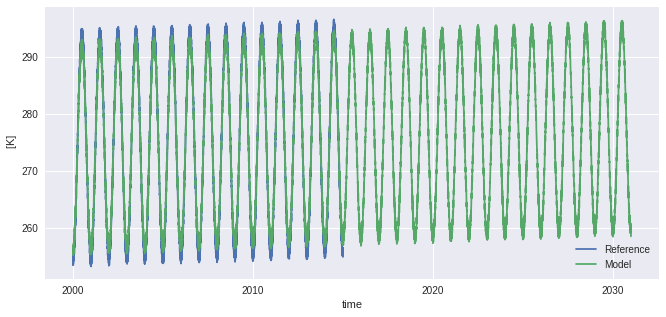

In [1]:
import numpy as np
import xarray as xr
import cftime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (11, 5)

# Create toy data to explore bias adjustment, here fake temperature timeseries
t = xr.cftime_range('2000-01-01', '2030-12-31', freq='D', calendar='noleap')
ref = xr.DataArray((-20 * np.cos(2 * np.pi * t.dayofyear / 365) + 2 * np.random.random_sample((t.size,)) + 273.15
                    + 0.1 * (t - t[0]).days / 365),  # "warming" of 1K per decade,
                   dims=('time',), coords={'time': t}, attrs={'units': 'K'})
sim = xr.DataArray((-18 * np.cos(2 * np.pi * t.dayofyear / 365) + 2 * np.random.random_sample((t.size,)) + 273.15
                    + 0.11 * (t - t[0]).days / 365),  # "warming" of 1.1K per decade
                   dims=('time',), coords={'time': t}, attrs={'units': 'K'})

ref = ref.sel(time=slice(None, '2015-01-01'))
hist = sim.sel(time=slice(None, '2015-01-01'))

ref.plot(label='Reference')
sim.plot(label='Model')
plt.legend()

/home/phobos/Python/xclim/xclim/indices/_multivariate.py:18: UserWarning: xclim.indices.generic has been refactored in xclim v0.21.0 and has moved several functions to 'xclim.indices.stats'. The affected functions are as follows: `fit`, `parametric_quantile`, `fa`, `frequency_analysis`, `get_dist`, `get_lm3_dist`, `_fit_start`, `_lm3_dist_map`. They have been made available here for your convenience. This functionality will change in xclim v0.22.0. Please update your scripts accordingly.
  from .generic import select_resample_op


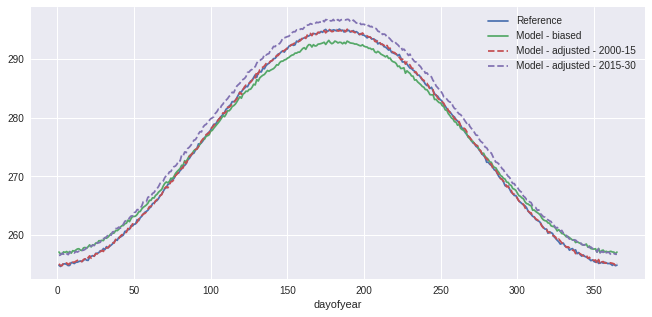

In [2]:
from xclim import sdba

QM = sdba.EmpiricalQuantileMapping(nquantiles=15, group='time', kind='+')
QM.train(ref, hist)
scen = QM.adjust(sim, extrapolation='constant', interp='nearest')

ref.groupby('time.dayofyear').mean().plot(label='Reference')
hist.groupby('time.dayofyear').mean().plot(label='Model - biased')
scen.sel(time=slice('2000', '2015')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2000-15', linestyle='--')
scen.sel(time=slice('2015', '2030')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2015-30', linestyle='--')
plt.legend()

In the previous example, a simple Quantile Mapping algorithm was used with 15 quantiles and one group of values. The model performs well, but our toy data is also quite smooth and well-behaved so this is not surprising. A more complex example could have biais distribution varying strongly across months. To perform the adjustment with different factors for each months, one can pass `group='time.month'`. Moreover, to reduce the risk of sharp change in the adjustment at the interface of the months, `interp='linear'` can be passed to `adjust` and the adjustment factors will be interpolated linearly. Ex: the factors for the 1st of May will be the average of those for april and those for may. This option is currently only implemented for monthly grouping.

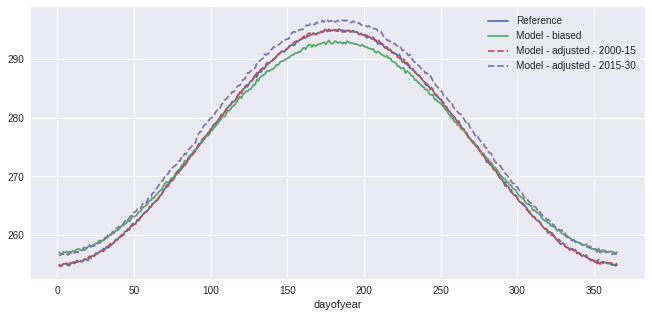

In [3]:
QM_mo = sdba.EmpiricalQuantileMapping(nquantiles=15, group='time.month', kind='+')
QM_mo.train(ref, hist)
scen = QM_mo.adjust(sim, extrapolation='constant', interp='linear')

ref.groupby('time.dayofyear').mean().plot(label='Reference')
hist.groupby('time.dayofyear').mean().plot(label='Model - biased')
scen.sel(time=slice('2000', '2015')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2000-15', linestyle='--')
scen.sel(time=slice('2015', '2030')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2015-30', linestyle='--')
plt.legend()

The training data (here the adjustment factors) is available for inspection in the `ds` attribute of the adjustment object.

In [4]:
QM_mo.ds

<xarray.Dataset>
Dimensions:    (month: 12, quantiles: 17)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.03333 0.1 0.1667 ... 0.9 0.9667 1.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    af         (month, quantiles) float64 -1.988 -1.988 -2.022 ... -1.613 -2.038
    hist_q     (month, quantiles) float64 255.3 255.8 256.4 ... 259.7 260.7
Attributes:
    adj_params:  EmpiricalQuantileMapping(nquantiles=15, kind='+', group=Grou...

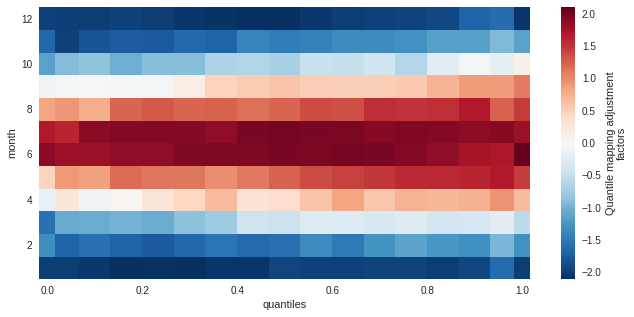

In [5]:
QM_mo.ds.af.plot()

## Grouping

For basic time period grouping (months, day of year, season), passing a string to the methods needing it is sufficient. Most methods acting on grouped data also accept a `window` int argument to pad the groups with data from adjacent ones. Units of `window` are the sampling frequency of the main grouping dimension (usually `time`). For more complex grouping, one can pass a :py:class:`xclim.sdba.base.Grouper` directly.

Example here with another, simpler, adjustment method. Here we want `sim` to be scaled so that its mean fits the one of `ref`. Scaling factors are to be computed separately for each day of the year, but including 15 days on either side of the day. This means that the factor for the 1st of May is computed including all values from the 16th of April to the 15th of May (of all years).

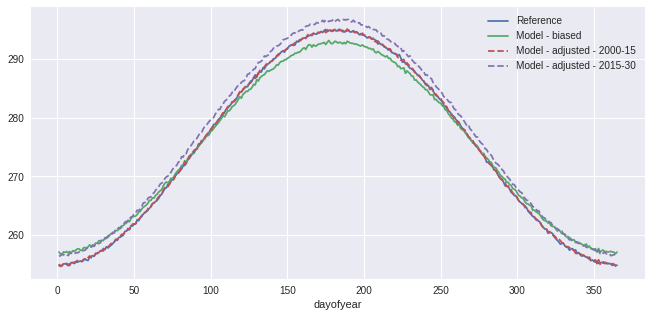

In [6]:
group = sdba.Grouper('time.dayofyear', window=31)
QM_doy = sdba.Scaling(group=group, kind='+')
QM_doy.train(ref, hist)
scen = QM_doy.adjust(sim)

ref.groupby('time.dayofyear').mean().plot(label='Reference')
hist.groupby('time.dayofyear').mean().plot(label='Model - biased')
scen.sel(time=slice('2000', '2015')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2000-15', linestyle='--')
scen.sel(time=slice('2015', '2030')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2015-30', linestyle='--')
plt.legend()

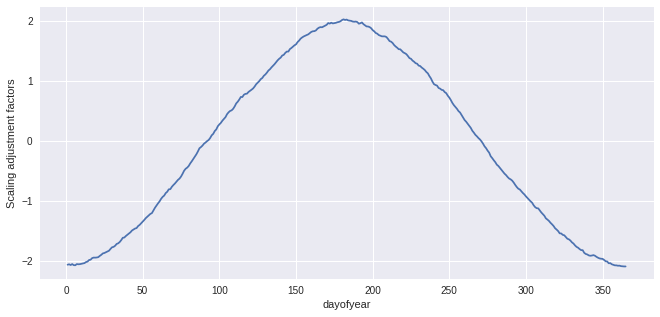

In [7]:
QM_doy.ds.af.plot()

## Modular approach

The `sdba` module adopts a modular approach instead of implementing published and named methods directly.
A generic bias adjustment process is laid out as follows:

- preprocessing on `ref`, `hist` and `sim` (using methods in `xclim.sdba.processing` or `xclim.sdba.detrending`)
- creating the adjustment object `Adj = Adjustment(**kwargs)` (from `xclim.sdba.adjustment`)
- training `Adj.train(obs, sim)`
- adjustment `scen = Adj.adjust(sim, **kwargs)`
- post-processing on `scen` (for example: re-trending)

The train-adjust approach allows to inspect the trained adjustment object. The training information is stored in the underlying `Adj.ds` dataset and always has a `af` variable with the adjustment factors. Its layout and the other available variables vary between the different algorithm, refer to their part of the API docs.

Parameters needed by the training and the adjustment are saved to the `Adj.ds` dataset as a  `adj_params` attribute. Other parameters, those only needed by the adjustment are passed in the `adjust` call and written to the history attribute in the output scenario dataarray.

### First example : pr and frequency adaptation

The next example generates fake precipitation data and adjusts the `sim` timeseries but also adds a step where the dry-day frequency of `hist` is adapted so that is fits the one of `ref`. This ensures well-behaved adjustment factors for the smaller quantiles. Note also that we are passing `kind='*'` to use the multiplicative mode. Adjustment factors will be multiplied/divided instead of being added/substracted.

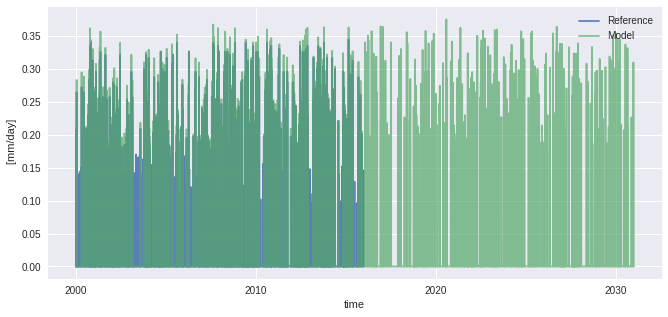

In [8]:
vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals/ 100, vals)) / 3e6
vals_sim = (1 + 0.1 * np.random.random_sample((t.size,))) * (4 ** np.where(vals < 9.5, vals/ 100, vals)) / 3e6

pr_ref = xr.DataArray(vals_ref, coords={"time": t}, dims=("time",), attrs={'units': 'mm/day'})
pr_ref = pr_ref.sel(time=slice('2000', '2015'))
pr_sim = xr.DataArray(vals_sim, coords={"time": t}, dims=("time",), attrs={'units': 'mm/day'})
pr_hist = pr_sim.sel(time=slice('2000', '2015'))

pr_ref.plot(alpha=0.9, label='Reference')
pr_sim.plot(alpha=0.7, label='Model')
plt.legend()

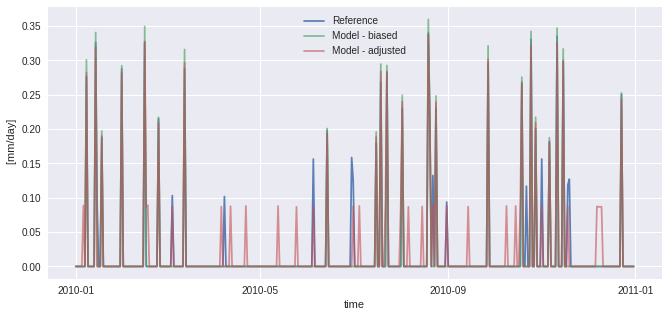

In [9]:
# 1st try without adapt_freq
QM = sdba.EmpiricalQuantileMapping(nquantiles=15, kind='*', group='time')
QM.train(pr_ref, pr_hist)
scen = QM.adjust(pr_sim)

pr_ref.sel(time='2010').plot(alpha=0.9, label='Reference')
pr_hist.sel(time='2010').plot(alpha=0.7, label='Model - biased')
scen.sel(time='2010').plot(alpha=0.6, label='Model - adjusted')
plt.legend()

In the figure above, `scen` has small peaks where `sim` is 0. This problem originates from the fact that there are more "dry days" (days with almost no precipitation) in `hist` than in `ref`. The next example works around the problem using frequency-adaptation, as described in [Themeßl et al. (2010)](https://doi.org/10.1007/s10584-011-0224-4).

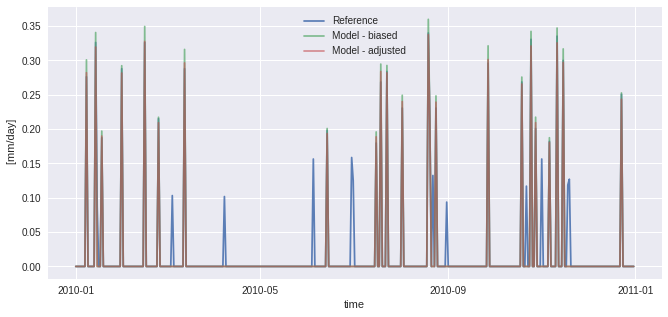

In [10]:
# 2nd try with adapt_freq
ds_ad = sdba.processing.adapt_freq(sim=pr_hist, ref=pr_ref, thresh=0.05)
QM_ad = sdba.EmpiricalQuantileMapping(nquantiles=15, kind='*', group='time')
QM_ad.train(pr_ref, ds_ad.sim_ad)
scen_ad = QM_ad.adjust(pr_sim)

pr_ref.sel(time='2010').plot(alpha=0.9, label='Reference')
pr_sim.sel(time='2010').plot(alpha=0.7, label='Model - biased')
scen_ad.sel(time='2010').plot(alpha=0.6, label='Model - adjusted')
plt.legend()

### Second example: tas and detrending

The next example reuses the fake temperature timeseries generated at the beginning and applies the same QM adjustment method. However, for a better adjustment, we will scale sim to ref and then detrend the series, assuming the trend is linear. When `sim` (or `sim_scl`) is detrended, its values are now anomalies, so we need to normalize `ref` and `hist` so we can compare similar values.

This process is detailed here to show how the sdba module should be used in custom adjustment processes, but this specific method also exists as `sdba.DetrendedQuantileMapping` and is based on [Cannon et al. 2015](https://doi.org/10.1175/JCLI-D-14-00754.1). However, `DetrendedQuantileMapping` normalizes over a `time.dayofyear` group, regardless of what is passed in the  `group` argument. As done here, it is anyway recommended to use `dayofyear` groups when normalizing, especially for variables with strong seasonal variations.

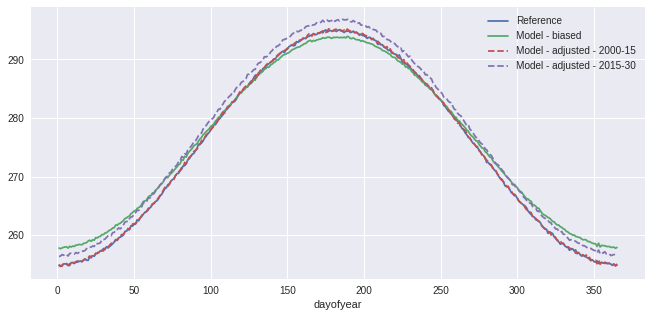

In [11]:
doy_win31 = sdba.Grouper('time.dayofyear', window=15)
Sca = sdba.Scaling(group=doy_win31, kind='+')
Sca.train(ref, hist)
sim_scl = Sca.adjust(sim)

detrender = sdba.detrending.PolyDetrend(degree=1, group='time.dayofyear', kind='+')
sim_fit = detrender.fit(sim_scl)
sim_detrended = sim_fit.detrend(sim_scl)

ref_n = sdba.processing.normalize(ref, group=doy_win31, kind='+')
hist_n = sdba.processing.normalize(hist, group=doy_win31, kind='+')

QM = sdba.EmpiricalQuantileMapping(nquantiles=15, group='time.month', kind='+')
QM.train(ref_n, hist_n)
scen_detrended = QM.adjust(sim_detrended, extrapolation='constant', interp='nearest')
scen = sim_fit.retrend(scen_detrended)


ref.groupby('time.dayofyear').mean().plot(label='Reference')
sim.groupby('time.dayofyear').mean().plot(label='Model - biased')
scen.sel(time=slice('2000', '2015')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2000-15', linestyle='--')
scen.sel(time=slice('2015', '2030')).groupby('time.dayofyear').mean().plot(label='Model - adjusted - 2015-30', linestyle='--')
plt.legend()

### Third example : Multi-method protocol - Hnilica et al. 2017
In [their paper of 2017](https://doi.org/10.1002/joc.4890), Hnilica, Hanel and Puš present a bias-adjustment method based on the principles of Principal Components Analysis. The idea is simple : use principal components to define coordinates on the reference and on the simulation and then transform the simulation data from the latter to the former. Spatial correlation can thus be conserved by taking different points as the dimensions of the transform space. The method was demonstrated in the article by bias-adjusting precipitation over different drainage basins.

Here we show how the modularity of `xclim.sdba` can be used to construct a quite complex adjustment protocol involving two adjustment methods : quantile mapping and principal components. Evidently, as this example uses only 2 years of data, it is not complete. It is meant to show how the adjustment functions and how the API can be used.

In [12]:
# We are using xarray's "air_temperature" dataset
ds = xr.tutorial.open_dataset("air_temperature")
# To get an exagerated example we select different points
# here "lon" will be our dimension of two "spatially correlated" points
reft = ds.air.isel(lat=21, lon=[40, 52]).drop_vars(["lon", "lat"])
simt = ds.air.isel(lat=18, lon=[17, 35]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = sdba.PrincipalComponents(group="time", crd_dims=['lon'])
PCA.train(reft, simt)
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = sdba.EmpiricalQuantileMapping(group='time', nquantiles=50, kind='+')
EQM.train(reft, scen1)
scen2 = EQM.adjust(scen1)

/home/phobos/.conda/envs/xclim-dev/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/phobos/.conda/envs/xclim-dev/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/phobos/.conda/envs/xclim-dev/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Text(0.5, 1.0, 'Timeseries - Point 1')

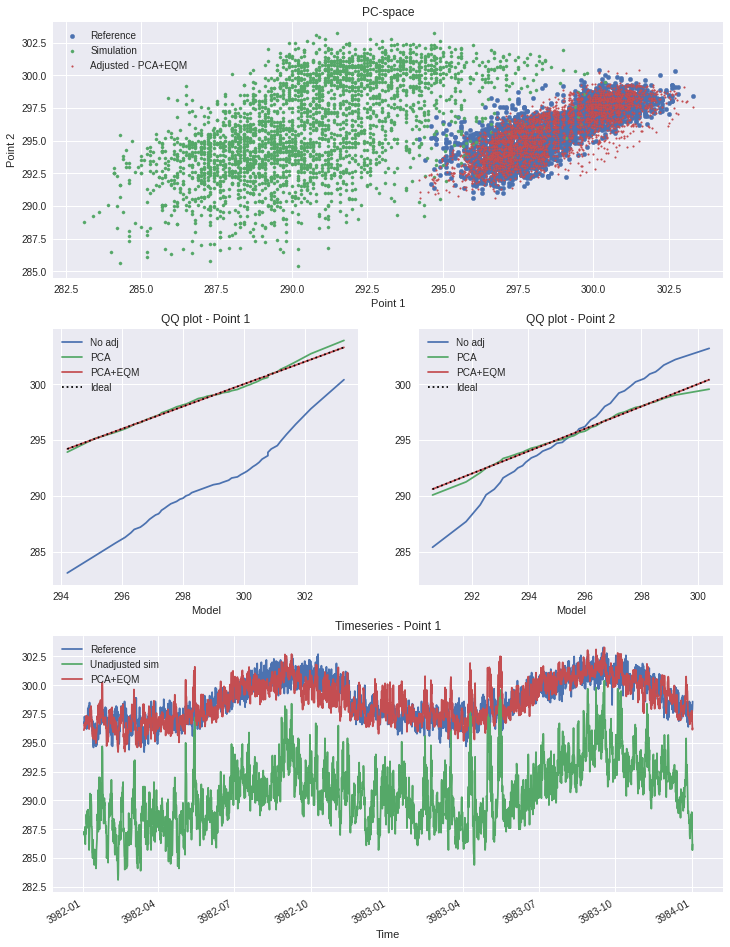

In [13]:
# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)

axPCA = plt.subplot(gs[0, :])
axPCA.scatter(reft.isel(lon=0), reft.isel(lon=1), s=20, label='Reference')
axPCA.scatter(simt.isel(lon=0), simt.isel(lon=1), s=10, label='Simulation')
axPCA.scatter(scen2.isel(lon=0), scen2.isel(lon=1), s=3, label='Adjusted - PCA+EQM')
axPCA.set_xlabel('Point 1')
axPCA.set_ylabel('Point 2')
axPCA.set_title('PC-space')
axPCA.legend()

refQ = reft.quantile(EQM.ds.quantiles, dim='time')
simQ = simt.quantile(EQM.ds.quantiles, dim='time')
scen1Q = scen1.quantile(EQM.ds.quantiles, dim='time')
scen2Q = scen2.quantile(EQM.ds.quantiles, dim='time')
for i in range(2):
    if i == 0:
        axQM = plt.subplot(gs[1, 0])
    else:
        axQM = plt.subplot(gs[1, 1], sharey=axQM)
    axQM.plot(refQ.isel(lon=i), simQ.isel(lon=i), label='No adj')
    axQM.plot(refQ.isel(lon=i), scen1Q.isel(lon=i), label='PCA')
    axQM.plot(refQ.isel(lon=i), scen2Q.isel(lon=i), label='PCA+EQM')
    axQM.plot(refQ.isel(lon=i), refQ.isel(lon=i), color='k', linestyle=':', label='Ideal')
    axQM.set_title(f'QQ plot - Point {i + 1}')
    axQM.set_xlabel('Reference')
    axQM.set_xlabel('Model')
    axQM.legend()

axT = plt.subplot(gs[2, :])
reft.isel(lon=0).plot(ax=axT, label='Reference')
simt.isel(lon=0).plot(ax=axT, label='Unadjusted sim')
#scen1.isel(lon=0).plot(ax=axT, label='PCA only')
scen2.isel(lon=0).plot(ax=axT, label='PCA+EQM')
axT.legend()
axT.set_title('Timeseries - Point 1')

## Optimization with dask

Adjustment process can be very heavy as they are made of large amounts of small operation and often needs to be computed over large regions. Using small groupings (like `time.dayofyear`) adds precision and robustness, but also decuplates the load and computing complexity. A good first read on this are xarray's [Optimization tips](http://xarray.pydata.org/en/stable/dask.html#optimization-tips).

Some additionnal tips:

* When saving a file with `to_netcdf`, setting option `unlimited_dims` with a list of dimension names can force xarray to write the data using chunks on disk, instead of one contiguous array. Command-line tool `ncdump -sh` can give information on how those chunks are oriented on disk and the optimal `chunks={...}` choice can be inferred.
* Most adjustment method will need to perform operation on the whole `time` coordinate, so it is best to optimize chunking along the other dimensions.
* One of the main bottleneck for adjustments with small groups is that dask needs to build and optimize an enormous task graph. In order to ease that process and reduce the number of recalculations, given that the training dataset fits in memory, one could call `Adjustment.ds.load()` to trigger the computation and store the result as a `np.array`. For very large tasks, one could write the training dataset to disk and then reload them into the `Adjustment` object.
* Consider using `engine="h5netcdf"` in `open_[mf]dataset` when possible. Compatibility of a file can be found using the `is_hdf5()` method of the `h5py` module.

### Example

The following script is an example of some methods useful to improve performances of a simple detrended quantile mapping adjustment. As we are using the sample data of previous example, dask isn't even needed here, and performance of this cell cannot be compared with what would happen on very large datasets.

In [14]:
ref.name = 'tas'
ref = ref.expand_dims(lon=[50, 60, 70, 80, 90, 100])
ref.to_dataset().to_netcdf('reference_data.nc', unlimited_dims=['lon'])
sim.name = 'tas'
sim = sim.expand_dims(lon=[50, 60, 70, 80, 90, 100])
sim.to_dataset().to_netcdf('simulation_data.nc', unlimited_dims=['lon'])

In [ ]:
var = "tas"
kind = '+'
ref_period = slice('2000', '2015')
sim_period = slice('2000', '2030')
file_ref = 'reference_data.nc'
file_sim = 'simulation_data.nc'

# We want the robustness of a dayofyear adjustment, but the speed of the monthly computation.
# The compromise is to split the normalization process from the quantile mapping. Smaller groups in normalization
# reduce the boundary effects between months but the monthly quantile mapping is almost as precise in that case.
# This is a scientific decision that should only be taken after careful analysis of the data, it is shown here as
# an example of compromise aimed at accelerating the computation.
g_norm = sdba.Grouper(group='time.dayofyear', window=31)
g_qm = sdba.Grouper(group='time.month')

# # Step 1 : Normalize hist and ref
maxlon = 6
nlon = 2

# Normalize (as resample() or groupby()) generates so many small operations that dask struggles
# to even start the computation. Here, with large data, it is more efficient to loop of the
# chunks and to **not** use dask. In the following two loops, "chunks=" is not assigned, so
# all data is loaded ad basic numpy operations are used.
for ilon in range(0, maxlon, nlon):
    # Using a `with` statement when opening a file automatically closes it when we exit the context.
    # As multiple open files can be sources of bugs, this helps the coding process
    with xr.open_dataset(file_ref)[var].isel(lon=slice(ilon, ilon + nlon)) as ref:
        da = sdba.processing.normalize(ref, group=g_norm, kind=kind)
        da.name = var
        da.to_netcdf(f"mydqm_{ilon:03d}_refn.nc", unlimited_dims=['lon'])
# Hist
for ilon in range(0, maxlon, nlon):
    with xr.open_dataset(file_sim)[var].isel(lon=slice(ilon, ilon + nlon)) as sim:
        da = sdba.processing.normalize(sim.sel(time=ref_period), group=g_norm, kind=kind)
        da.name = var
        da.to_netcdf(f"mydqm_{ilon:03d}_histn.nc", unlimited_dims=['lon'])

# reopen the files
# Here we specify the same chunking for all files, but different values could be used
# depending on the operations or the data.
ref = xr.open_dataset(file_ref, chunks={'lon': 2})[var]
hist = xr.open_dataset(file_sim, chunks={'lon': 2})[var].sel(time=ref_period)
refn = xr.open_mfdataset("mydqm_*_refn.nc", combine='by_coords')[var]
histn = xr.open_mfdataset("mydqm_*_histn.nc", combine='by_coords')[var]

# Step 2 - Empirical Quantile Mapping using the normalized data
EQM = sdba.EmpiricalQuantileMapping(nquantiles=50, kind=kind, group=g_qm)
EQM.train(refn, histn)
mu_ref = g_qm.apply("mean", ref)
mu_hist = g_qm.apply("mean", hist)
# EQM.ds is simply a dataset, it can be edited in place.
EQM.ds["scaling"] = sdba.utils.get_correction(mu_hist, mu_ref, '+')
EQM.ds.scaling.attrs.update(
    standard_name="Scaling factor",
    description="Scaling factor making the mean of hist match the one of hist.",
)
# We trigger the training dataset computations, it divides the workload.
EQM.ds.load()

# Step 3 - Normalize and scale sim
with xr.open_dataset(file_sim, chunks={'lon': 2})[var] as sim:
    sim_scl = sdba.utils.apply_correction(
        sim,
        sdba.utils.broadcast(EQM.ds.scaling, sim, group=g_qm, interp='linear'),
        kind=kind
    )
    # For faster computation and as it makes it identical to hist, we normalize sim only with the reference period.
    sim_norm = g_norm.apply("mean", sim_scl.sel(time=ref_period))
    sim_anom = sdba.utils.apply_correction(
        sim_scl,
        sdba.utils.broadcast(sdba.utils.invert(sim_norm, kind=kind), sim_scl, group=g_norm, interp='nearest'),
        kind=kind
    )
    xr.Dataset(data_vars={'norm': sim_norm, 'sim': sim_anom}).to_netcdf("dqm_simn.nc", unlimited_dims=['lon'])

# Step 4 - Detrending
# Detrending is one of the heaviest operations so the trend is saved in its own step.
ds_simn = xr.open_dataset("dqm_simn.nc", chunks={'lon': 2})
polyfit = sdba.detrending.PolyDetrend(group=g_qm, degree=2)
sim_fit = polyfit.fit(ds_simn.sim)
trend = sim_fit.get_trend(ds_simn.sim)
trend.name = 'trend'
trend.to_dataset().to_netcdf("dqm_sim_trend.nc", unlimited_dims=['lon'])

# Step 5 - Adjustment
with xr.open_dataset("dqm_sim_trend.nc", chunks={'lon': 2}) as ds_trend:
    # With the trend already computed, the "private" versions of detrend and retrend
    # can be used to skip the trend computation.
    sim_det = sim_fit._detrend(ds_simn.sim, ds_trend.trend)
    sim_det.name = 'sim'
    scen_det_anom = EQM.adjust(sim_det, interp='linear', extrapolation='constant')
    scen_anom = sim_fit._retrend(scen_det_anom, ds_trend.trend)
    scen = sdba.utils.apply_correction(
        scen_anom,
        sdba.utils.broadcast(ds_simn.norm, scen_anom, group=g_norm, interp='nearest'),
        kind=kind
    )
    scen.name = var
    scen.to_netcdf("dqm_scen.nc", unlimited_dims=['lon'])

# Cleanup
ref.close()
hist.close()
refn.close()
histn.close()
ds_simn.close()